# Bike Sharing Demand Kaggle Competition

Kaggle competition to predict bike sharing demand for each hour.

Data:
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

The data can be downloaded here: https://www.kaggle.com/c/bike-sharing-demand/data

Referred to this wonderful kernel
https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

### Import libraries

In [1]:
import os
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,RidgeCV,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Explore data

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


In [4]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [5]:
print(train.info()) #no null values
print(test.info()) #no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6

In [6]:
train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


### Augment columns from datetime variable

In [7]:
# Augment hour,month column to train and test datasets
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train['hour'] = train['datetime'].dt.hour
test['hour'] = test['datetime'].dt.hour

train['day'] = train['datetime'].dt.weekday
test['day'] = test['datetime'].dt.weekday

train['month'] = train['datetime'].dt.month
test['month'] = test['datetime'].dt.month

train['year'] = train['datetime'].dt.year
test['year'] = test['datetime'].dt.year

### Explore dependent variable 'count'

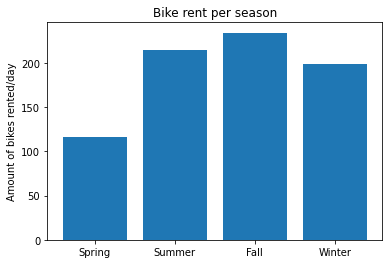

In [8]:
count_per_season = train.groupby(['season'])['count'].mean()

plt.bar(['Spring', 'Summer', 'Fall', 'Winter'], count_per_season)
plt.title('Bike rent per season')
plt.ylabel('Amount of bikes rented/day')
plt.show()

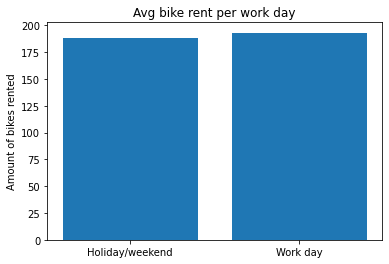

In [9]:
count_per_workday = train.groupby(['workingday'])['count'].mean()
plt.bar(['Holiday/weekend', 'Work day'], count_per_workday)
plt.title('Avg bike rent per work day')
plt.ylabel('Amount of bikes rented')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

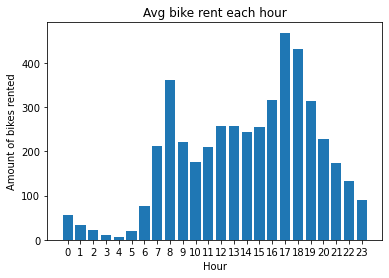

In [10]:
count_each_hour = train.groupby(['hour'])['count'].mean()
plt.bar(range(0,24), count_each_hour)
plt.title('Avg bike rent each hour')
plt.xlabel('Hour')
plt.ylabel('Amount of bikes rented')
plt.xticks(range(0,24))
plt.show()

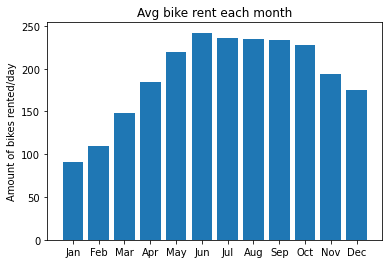

In [11]:
count_each_month = train.groupby(['month'])['count'].mean()
plt.bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], count_each_month)
plt.title('Avg bike rent each month')
plt.ylabel('Amount of bikes rented/day')
plt.show()

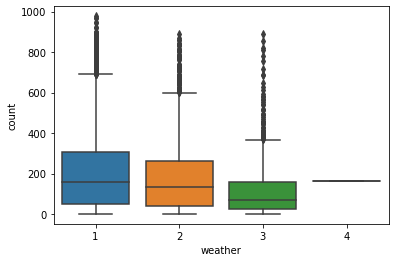

In [12]:
sns.boxplot(x= 'weather', data = train, y = 'count')
plt.show()

* We can notice that Fall is the most popular season for bike renting, while Spring is the least popular.  We might have to investigate the reasons for that furhter down the road
* There does **not** seem to be a significant difference between the bike rental amount on holidays/weekends and workdays 
* Two peaks in the hourly graph indicate that there is a big demand around **8am** and **5pm** for bikes.  The reasons can be quite intuitive - biking early in the morning (before work) or in the afternoon (after work). 
* Weather and bike rental count are negatively correlated as expected. The worse the weather, the less bikes rented


### Converting categorigal variables to 'category'

In [14]:
varList = ['season', 'holiday', 'workingday', 'weather', 'hour', 'month', 'day', 'year']
for var in varList:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

### Correlation matrix (for numerical features)

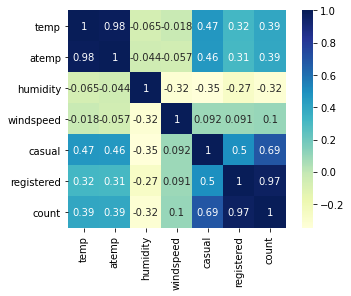

In [15]:
corr = train.corr()

sns.heatmap(corr, square = True, annot = True, cmap="YlGnBu")
plt.show()

Humidity is negatively correlated with count.  We can see that **temp** and **atemp** are highly correlated together (0.98).  It is safe to drop one of the features since both have the same correlation coefficent with the target variable count (0.39).  I will drop the **atemp** variable, which indicates what the temperature feels like outside. 

In [16]:
# Drop atemp column
train.drop('atemp', axis = 1, inplace = True)
test.drop('atemp', axis = 1, inplace = True)

### Inspect 'windspeed' column 

In [17]:
train['windspeed'].describe()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

In [18]:
len(train[train['windspeed'] == 0])

1313

There are 1313 values in train data that equal 0 in the **windspeed** column.  I suspect that to be missing data.  We will predict the windspeed value to impute missing data using **Random Forest Regressor**

In [19]:
# Concat the datasets
df = train.append(test)

In [20]:
# Get the data where windspeed is 0
no_wind = df[df['windspeed'] == 0]
wind = df[df['windspeed'] != 0]

In [21]:
# I will use Random Forest to predict windspeed values
rf_wind = RandomForestRegressor()

In [22]:
# Split data to X and y
X_wind = wind[['season','weather', 'temp', 'humidity', 'hour', 'day', 'month']]
y_wind = wind['windspeed']

In [23]:
# Fit the model to learn variable dependencies
rf_wind.fit(X_wind, y_wind)

RandomForestRegressor()

In [24]:
# Predict windspeed 
no_wind_data = no_wind[['season','weather', 'temp', 'humidity', 'hour', 'day', 'month']]
no_wind_pred = rf_wind.predict(no_wind_data)
no_wind['windspeed'] = no_wind_pred

<ipython-input-24-758010f143ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_wind['windspeed'] = no_wind_pred


In [25]:
# Join datasets back together
data = wind.append(no_wind)

### Prepare data for ML algorithms

The competition is scored using Root Mean Squared Logarithmic Error. Let's define the function that scores out predicitions

In [26]:
def rmsle(y, y1):
    log1 = np.nan_to_num(np.array([np.log1p(v) for v in y]))
    log2 = np.nan_to_num(np.array([np.log1p(v) for v in y1]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [27]:
# Get dummy variables
data = pd.get_dummies(data, columns=['season', 'holiday', 'workingday', 'weather', 'hour', 'month', 'day', 'year'])

In [28]:
# Split data back to train and test
train = data[data['count'].notna()].sort_values(by = ['datetime'])
test = data[data['count'].isna()].sort_values(by = ['datetime'])
y = train['count']

In [29]:
# Drop datetime, registered, casual columns
train = train.drop(['datetime', 'registered', 'casual', 'count'], axis = 1)
datetime = test['datetime']
test = test.drop(['datetime', 'registered', 'casual', 'count'], axis = 1)

In [30]:
X = train.copy()

In [31]:
# Scale data for algorithms that benefit from it
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
test_scaled = sc.transform(test)

In [32]:
# Split data into training and testing data sets for both scaled and unscaled data
X_train_sc, X_test_sc, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Visualize the distribution of 'count' variable

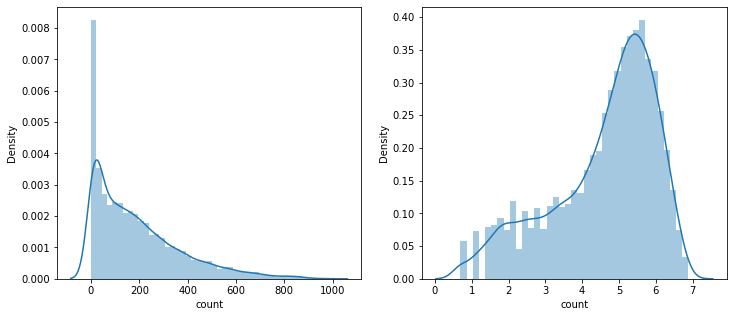

In [33]:
f, ax = plt.subplots(1,2)
f.set_size_inches(12,5)
sns.distplot(y, ax = ax[0])
sns.distplot(np.log1p(y), ax=ax[1])
plt.show()

It seems that the transformation will make the model more accurate as the dependent variable distribution looks much closer to normal. We will transform the target variable before machine learning algorithms

In [34]:
# Transform using log1p
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

### Linear Regression

In [35]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_sc, y_train)
pred = lin_reg.predict(X_test_sc)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(y_test),np.exp(pred)))

RMSLE Value For Linear Regression:  0.5518553967931474


RMSLE Value For Linear Regression:  0.5518553967931474

### Ridge Regression

In [36]:
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
ridge = RidgeCV(alphas = [0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000], scoring = rmsle_scorer, cv = 10)
ridge.fit(X_train_sc, y_train)
pred = ridge.predict(X_test_sc)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(y_test),np.exp(pred)))

RMSLE Value For Ridge Regression:  0.5518182187233358


RMSLE Value For Ridge Regression:  0.5518182187233358

### Random Forest Regression

In [37]:
rf = RandomForestRegressor(n_estimators=300)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(y_test),np.exp(pred)))

RMSLE Value For Random Forest:  0.30228045429042494


RMSLE Value For Random Forest:  0.30228045429042494

### Gradient Boost

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)


gbm.fit(X_train, y_train)
preds = gbm.predict(X_test)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(y_test),np.exp(preds)))

RMSLE Value For Gradient Boost:  0.29018952604836273


RMSLE Value For Gradient Boost:  0.29018952604836273

In [39]:
# Grid search for best parameter values
gbm = GradientBoostingRegressor()
params = {'n_estimators': [4000], 'alpha': [0.1, .05, .15]}

# Make scorer using rmsle
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

grid_gbm = GridSearchCV( gbm,
                          params,
                          scoring = rmsle_scorer,
                          cv=3)

grid_gbm.fit(X_train, y_train)

preds = grid_gbm.predict(X= X_test)
print (grid_gbm.best_params_)
print ("RMSLE Value For Gradient Bossing Regressor is: ",rmsle(np.exp(y_test),np.exp(preds)))

{'alpha': 0.05, 'n_estimators': 4000}
RMSLE Value For Gradient Bossing Regressor is:  0.2902053164448529


Best params: alpha: **0.05**

In [42]:
# Make final predictions
yy = np.log1p(y)

gbm = GradientBoostingRegressor(n_estimators = 4000, alpha = .05)
gbm.fit(X, yy)

predsTest = gbm.predict(X=test)

# Make submission, transforming predictions back to appropriate scale
submission = pd.DataFrame({
        "datetime": datetime,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('sub.csv', index=False)

#### .39641 score on Kaggle